In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)


Mounted at /content/gdrive/


In [ ]:
!unzip /content/gdrive/MyDrive/Colab\ Notebooks/data.zip

Streaming output truncated to the last 5000 lines.
 extracting: data/Train/5/00005_00053_00014.png  
 extracting: data/Train/5/00005_00053_00015.png  
 extracting: data/Train/5/00005_00053_00016.png  
 extracting: data/Train/5/00005_00053_00017.png  
 extracting: data/Train/5/00005_00053_00018.png  
 extracting: data/Train/5/00005_00053_00019.png  
 extracting: data/Train/5/00005_00053_00020.png  
 extracting: data/Train/5/00005_00053_00021.png  
 extracting: data/Train/5/00005_00053_00022.png  
 extracting: data/Train/5/00005_00053_00023.png  
 extracting: data/Train/5/00005_00053_00024.png  
 extracting: data/Train/5/00005_00053_00025.png  
 extracting: data/Train/5/00005_00053_00026.png  
 extracting: data/Train/5/00005_00053_00027.png  
 extracting: data/Train/5/00005_00053_00028.png  
 extracting: data/Train/5/00005_00053_00029.png  
 extracting: data/Train/5/00005_00054_00000.png  
 extracting: data/Train/5/00005_00054_00001.png  
 extracting: data/Train/5/00005_00054_00002.png  

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import os
import pathlib
import random as rn
from sklearn.model_selection import train_test_split
#import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from sklearn.metrics import accuracy_score
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import csv
import numpy as np
from time import time
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG19
import matplotlib.pyplot as plt
%matplotlib inline

Num GPUs Available:  1


In [ ]:
path = os.getcwd()
data_dir = path+'/data'
train_path = path+'/data/Train/'
test_path = path+'/data/Test/'
height = 224
width = 224

In [ ]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [ ]:
batch_size = 150
seed = 42

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)
train_dataset = train_datagen.flow_from_directory(train_path,
                                                  target_size=(height, width),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  seed=seed,
                                                  color_mode='rgb',
                                                  interpolation='hamming',
                                                  subset='training')

test_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split=0.2)
test_dataset = test_datagen.flow_from_directory(train_path,
                                                target_size=(height, width),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True,
                                                seed=seed,
                                                color_mode='rgb',
                                                interpolation='hamming',
                                                subset='validation')

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


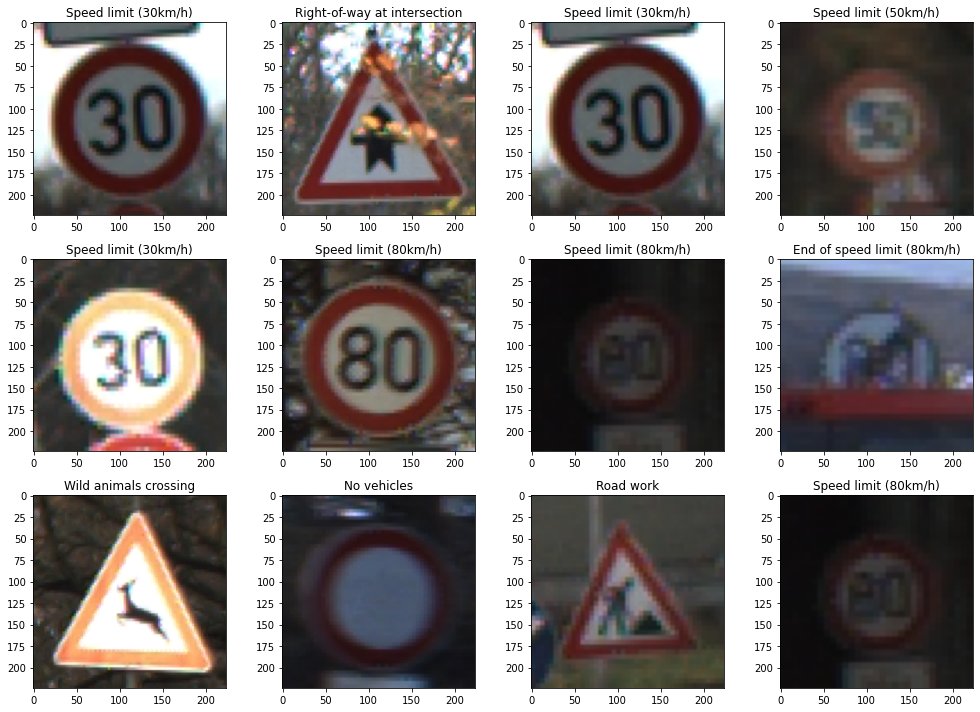

In [ ]:
fig,ax=plt.subplots(3,4)
fig.set_size_inches(14,10)
img,y = train_dataset.next()
for i in range(3):
    for j in range (4):
        l=rn.randint(0,batch_size-1)
        label = classes[int(list(train_dataset.class_indices.keys())[np.argmax(y[l])])]
        ax[i,j].imshow(img[l])
        ax[i,j].set_title(label)

plt.tight_layout()

In [ ]:

# Load the VGG16 model pre-trained on ImageNet
vgg16_model = keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the VGG16 model
for layer in vgg16_model.layers:
    layer.trainable = False

# Create the model for classifying traffic road signs
model = Sequential()

# Add the VGG16 model as the first layer of the model
model.add(vgg16_model)

# Add a flatten layer to the model
model.add(Flatten())

# Add a fully-connected layer with 128 units and ReLU activation
model.add(Dense(128, activation='relu'))

# Add a dropout layer with a rate of 0.5
model.add(Dropout(0.5))

# Add a final fully-connected layer with the number of classes as the number of units and softmax activation
num_classes = 43  # Change this to the number of classes in your dataset
model.add(Dense(num_classes, activation='softmax'))

# Compile the model with Adam optimizer and categorical cross-entropy loss
#model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy']) 0.58 accuracy
alpha=0.001
epochs=4
optim = keras.optimizers.Adam(learning_rate=alpha)
model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 43)                5547      
                                                                 
Total params: 17,931,627
Trainable params: 3,216,939
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
vgg_history = model.fit(train_dataset,
                        steps_per_epoch=len(train_dataset),
                        epochs=10,
                        validation_data=test_dataset,
                        validation_steps=len(test_dataset))

Epoch 1/10
210/210 [==============================] - 71s 287ms/step - loss: 2.5953 - accuracy: 0.2735 - val_loss: 1.8177 - val_accuracy: 0.5132
Epoch 2/10
210/210 [==============================] - 59s 280ms/step - loss: 1.8840 - accuracy: 0.4140 - val_loss: 1.4584 - val_accuracy: 0.5773
Epoch 3/10
210/210 [==============================] - 58s 276ms/step - loss: 1.6349 - accuracy: 0.4706 - val_loss: 1.3086 - val_accuracy: 0.6233
Epoch 4/10
210/210 [==============================] - 57s 273ms/step - loss: 1.4789 - accuracy: 0.5120 - val_loss: 1.2261 - val_accuracy: 0.6406
Epoch 5/10
210/210 [==============================] - 57s 273ms/step - loss: 1.3904 - accuracy: 0.5315 - val_loss: 1.1134 - val_accuracy: 0.6706
Epoch 6/10
210/210 [==============================] - 57s 273ms/step - loss: 1.3084 - accuracy: 0.5543 - val_loss: 1.0545 - val_accuracy: 0.6935
Epoch 7/10
210/210 [==============================] - 57s 269ms/step - loss: 1.2592 - accuracy: 0.5678 - val_loss: 1.1060 - val_ac

In [ ]:
!mkdir /content/gdrive/My\ Drive/Colab_Models

In [ ]:
model.save('/content/gdrive/My Drive/Colab_Models/vgg_history.h5')

In [ ]:
vgg_history.history

{'loss': [2.595264434814453,
  1.8839884996414185,
  1.6348686218261719,
  1.4788568019866943,
  1.390385389328003,
  1.3083878755569458,
  1.259204387664795,
  1.195446252822876,
  1.1564981937408447,
  1.1268081665039062],
 'accuracy': [0.27349528670310974,
  0.41398876905441284,
  0.47063887119293213,
  0.512018620967865,
  0.5314651727676392,
  0.5542591214179993,
  0.5678079724311829,
  0.5876370668411255,
  0.5978066921234131,
  0.6034494042396545],
 'val_loss': [1.8176848888397217,
  1.4584211111068726,
  1.3086336851119995,
  1.2260582447052002,
  1.1133517026901245,
  1.0545241832733154,
  1.1060277223587036,
  1.0157469511032104,
  1.0125789642333984,
  1.005651831626892],
 'val_accuracy': [0.5131998658180237,
  0.577349841594696,
  0.623262345790863,
  0.6406070590019226,
  0.6705777049064636,
  0.6935340166091919,
  0.6473664045333862,
  0.6920035481452942,
  0.6811631321907043,
  0.6922586560249329]}

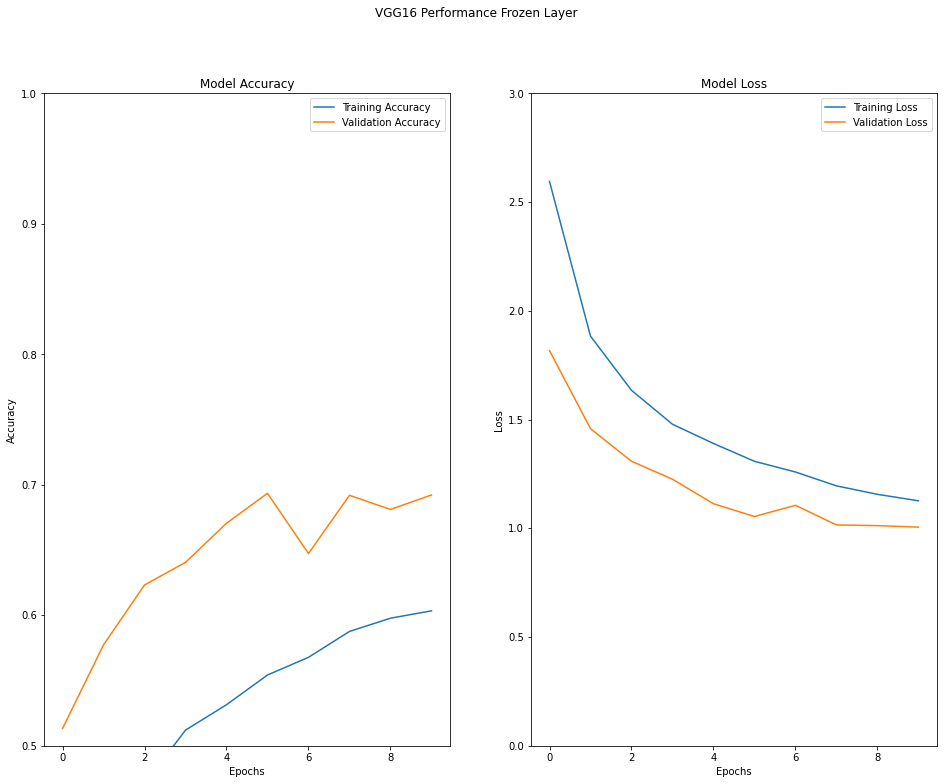

<Figure size 648x432 with 0 Axes>

In [ ]:
fig,ax=plt.subplots(1,2)
fig.set_size_inches(16,12)
performance = pd.DataFrame(vgg_history.history)
plt.figure(figsize=(9,6))
ax[1].plot(performance[['loss','val_loss']])
ax[1].legend(['Training Loss', 'Validation Loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_ylim(0,3)
ax[0].plot(performance[['accuracy','val_accuracy']])
ax[0].legend(['Training Accuracy', 'Validation Accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0.5,1)
fig.suptitle('VGG16 Performance Frozen Layer')
plt.show()

In [ ]:
def map_pred(pred):
    return [int(list(train_dataset.class_indices.keys())[i]) for i in pred]
test_df = pd.read_csv(data_dir + '/Test.csv')

test_labels = test_df["ClassId"].values
imgs = "/content/data/"+test_df["Path"].values

data =[]

for img in imgs:
      image = Image.open(img)
      image_fromarray = Image.fromarray(np.uint8(image)).convert('RGB')
      #image_fromarray = Image.fromarray(image, 'RGB')
      resize_image = image_fromarray.resize((height, width))
      data.append(np.array(resize_image))
    
    
    
    # try:
    #     image = cv2.imread(data_dir +img)
    #     image_fromarray = Image.fromarray(image, 'RGB')
    #     resize_image = image_fromarray.resize((height, width))
    #     data.append(np.array(resize_image))
    # except:
    #     print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

In [ ]:
imgs

array(['/data/Test/00000.png', '/data/Test/00001.png',
       '/data/Test/00002.png', ..., '/data/Test/12627.png',
       '/data/Test/12628.png', '/data/Test/12629.png'], dtype=object)

In [ ]:
from sklearn.metrics import accuracy_score
pred = model.predict(X_test)
pred = map_pred(pred.argmax(axis=-1))
print('Test Data accuracy: ',accuracy_score(test_labels, pred)*100)

395/395 [==============================] - 9s 24ms/step
Test Data accuracy:  58.92319873317498


5/5 [==============================] - 0s 25ms/step


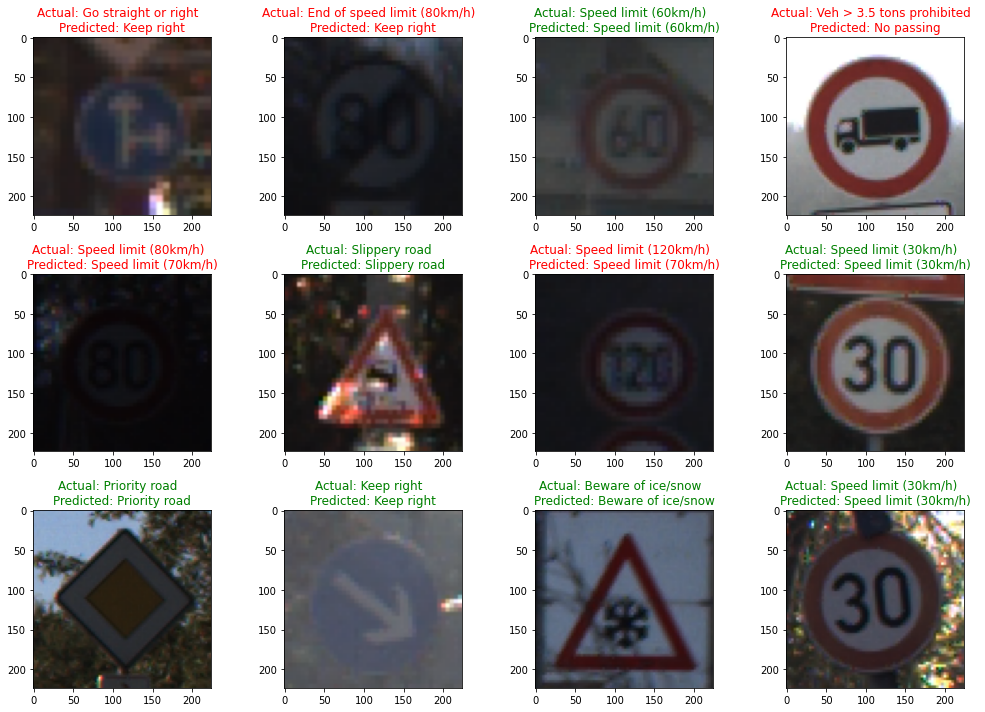

In [ ]:
fig,ax=plt.subplots(3,4)
fig.set_size_inches(14,10)
val_images, val_labels = test_dataset.next()
predicted = model.predict(val_images)
predicts = map_pred(np.argmax(predicted, axis=-1))
labels = map_pred(np.argmax(val_labels, axis=-1))
for i in range(3):
    for j in range (4):
        idx=rn.randint(0,batch_size-1)
        ax[i,j].imshow(val_images[idx])
        if labels[idx] == predicts[idx]:
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'green')
        else: 
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'red')

plt.tight_layout()

FINE TUNE MODEL


In [ ]:

# Load the VGG16 model pre-trained on ImageNet
vgg16_model = keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the VGG16 model
for layer in vgg16_model.layers:
    layer.trainable = True

# Create the model for classifying traffic road signs
model_fine = Sequential()

# Add the VGG16 model as the first layer of the model
model_fine.add(vgg16_model)

# Add a flatten layer to the model
model_fine.add(Flatten())

# Add a fully-connected layer with 128 units and ReLU activation
model_fine.add(Dense(128, activation='relu'))

# Add a dropout layer with a rate of 0.5
model_fine.add(Dropout(0.5))

# Add a final fully-connected layer with the number of classes as the number of units and softmax activation
num_classes = 43  # Change this to the number of classes in your dataset
model_fine.add(Dense(num_classes, activation='softmax'))

# Compile the model with Adam optimizer and categorical cross-entropy loss
#model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy']) 0.58 accuracy
alpha=0.001
epochs=4
optim = keras.optimizers.Adam(learning_rate=alpha)
model_fine.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model_fine.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               3211392   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 43)                5547      
                                                                 
Total params: 17,931,627
Trainable params: 17,931,627
Non-trainable params: 0
_________________________________________________________________


In [ ]:
vgg_fine = model_fine.fit(train_dataset,
                        steps_per_epoch=len(train_dataset),
                        epochs=10,
                        validation_data=test_dataset,
                        validation_steps=len(test_dataset))

Epoch 1/10
210/210 [==============================] - 73s 322ms/step - loss: 3.4827 - accuracy: 0.1023 - val_loss: 2.4239 - val_accuracy: 0.3090
Epoch 2/10
210/210 [==============================] - 67s 317ms/step - loss: 1.8133 - accuracy: 0.4318 - val_loss: 1.2471 - val_accuracy: 0.6097
Epoch 3/10
210/210 [==============================] - 66s 316ms/step - loss: 0.9805 - accuracy: 0.6802 - val_loss: 0.5691 - val_accuracy: 0.8365
Epoch 4/10
210/210 [==============================] - 67s 317ms/step - loss: 0.5256 - accuracy: 0.8318 - val_loss: 0.3336 - val_accuracy: 0.9126
Epoch 5/10
210/210 [==============================] - 67s 318ms/step - loss: 0.3075 - accuracy: 0.9023 - val_loss: 0.3022 - val_accuracy: 0.9217
Epoch 6/10
210/210 [==============================] - 68s 321ms/step - loss: 0.1966 - accuracy: 0.9388 - val_loss: 0.2176 - val_accuracy: 0.9438
Epoch 7/10
210/210 [==============================] - 67s 317ms/step - loss: 0.1430 - accuracy: 0.9550 - val_loss: 0.1887 - val_ac

In [ ]:
from sklearn.metrics import accuracy_score
pred = model_fine.predict(X_test)
pred = map_pred(pred.argmax(axis=-1))
print('Test Data accuracy: ',accuracy_score(test_labels, pred)*100)

395/395 [==============================] - 10s 24ms/step
Test Data accuracy:  94.83768804433888


In [ ]:
from sklearn.metrics import recall_score
pred = model_fine.predict(X_test)
pred = map_pred(pred.argmax(axis=-1))
print('Test Data accuracy: ',recall_score(t, pred))

395/395 [==============================] - 9s 23ms/step


ValueError: ignored

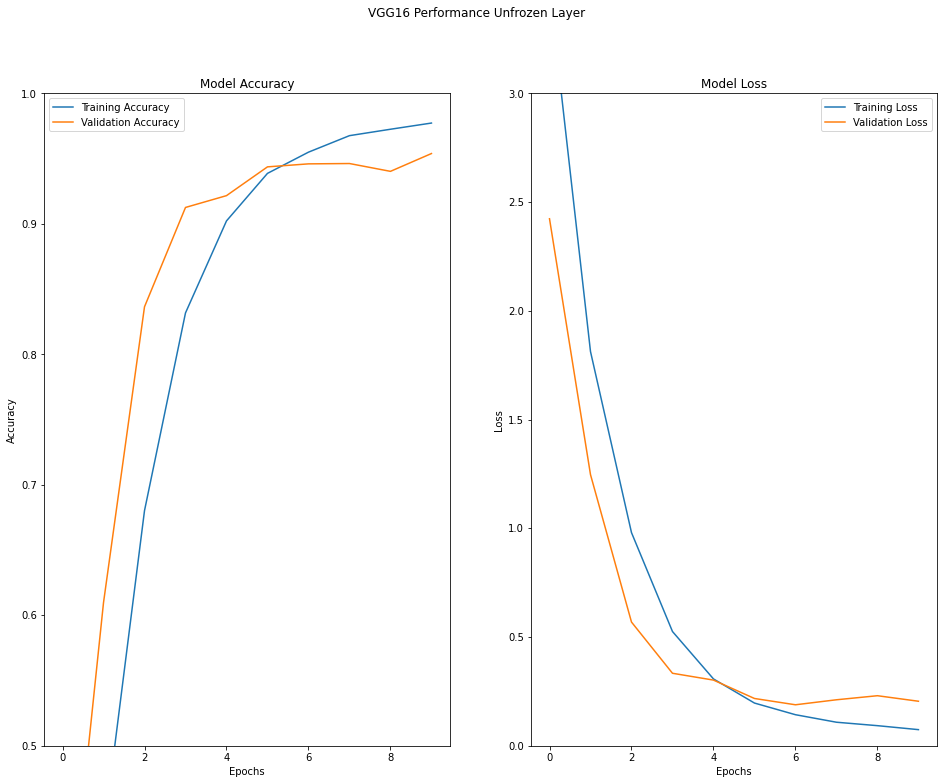

<Figure size 648x432 with 0 Axes>

In [ ]:
fig,ax=plt.subplots(1,2)
fig.set_size_inches(16,12)
performance = pd.DataFrame(vgg_fine.history)
plt.figure(figsize=(9,6))
ax[1].plot(performance[['loss','val_loss']])
ax[1].legend(['Training Loss', 'Validation Loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_ylim(0,3)
ax[0].plot(performance[['accuracy','val_accuracy']])
ax[0].legend(['Training Accuracy', 'Validation Accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0.5,1)
fig.suptitle('VGG16 Performance Unfrozen Layer')
plt.show()

5/5 [==============================] - 0s 25ms/step


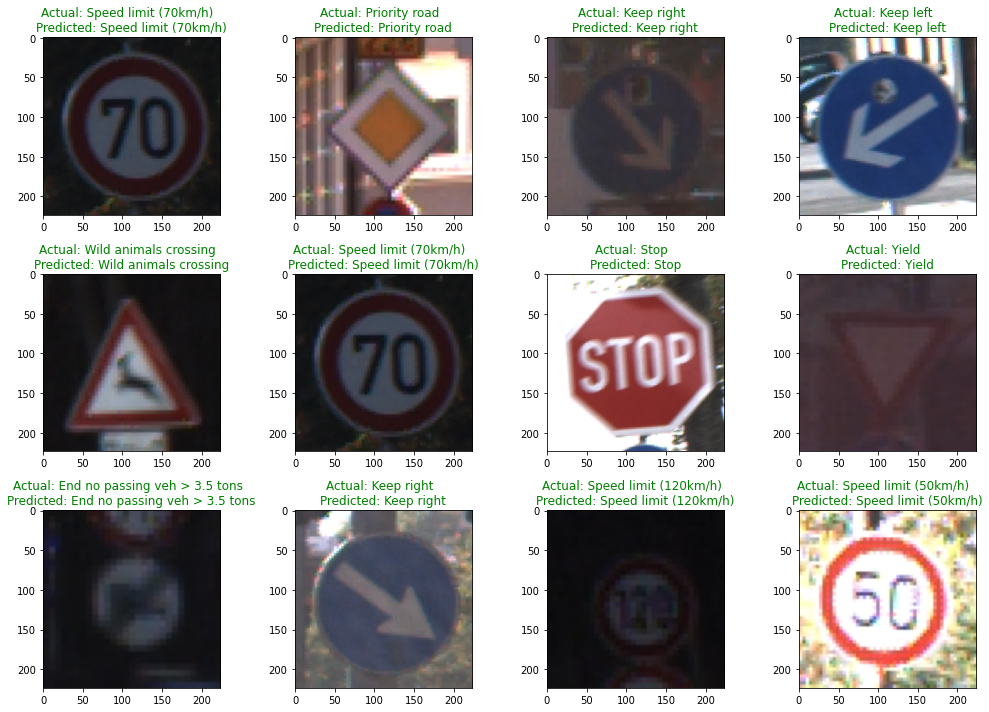

In [ ]:
fig,ax=plt.subplots(3,4)
fig.set_size_inches(14,10)
val_images, val_labels = test_dataset.next()
predicted = model_fine.predict(val_images)
predicts = map_pred(np.argmax(predicted, axis=-1))
labels = map_pred(np.argmax(val_labels, axis=-1))
for i in range(3):
    for j in range (4):
        idx=rn.randint(0,batch_size-1)
        ax[i,j].imshow(val_images[idx])
        if labels[idx] == predicts[idx]:
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'green')
        else: 
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'red')

plt.tight_layout()

In [ ]:
model.save('/content/gdrive/My Drive/Colab_Models/vgg_fine.h5')